In [ ]:
!git clone https://github.com/openai/multiagent-particle-envs

Cloning into 'multiagent-particle-envs'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (123/123), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 281 (delta 104), reused 88 (delta 88), pack-reused 158
Receiving objects: 100% (281/281), 109.97 KiB | 908.00 KiB/s, done.
Resolving deltas: 100% (158/158), done.


In [ ]:
!apt-get install -y xvfb > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install JSAnimation

In [ ]:
cd multiagent-particle-envs/

/content/multiagent-particle-envs/multiagent-particle-envs/multiagent-particle-envs/multiagent-particle-envs


In [ ]:
!pip install gym==0.10.5
!pip install pyglet==1.3.2
!pip install tianshou

In [ ]:
from make_env import make_env
import numpy as np
import copy
from collections import deque, namedtuple
import gym
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt


from typing import Any, List, Optional, Tuple, Union
from tianshou.data import Batch, ReplayBuffer, SegmentTree, to_numpy

from JSAnimation.IPython_display import display_animation
from IPython.display import HTML

In [ ]:
print(torch.cuda.device_count())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

1
cuda:0


In [ ]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Implementation of Prioritized Experience Replay. arXiv:1511.05952.

    :param float alpha: the prioritization exponent.
    :param float beta: the importance sample soft coefficient.
    :param bool weight_norm: whether to normalize returned weights with the maximum
        weight value within the batch. Default to True.

    .. seealso::

        Please refer to :class:`~tianshou.data.ReplayBuffer` for other APIs' usage.
    """
    def __init__(
        self,
        size: int,
        alpha: float,
        beta: float,
        weight_norm: bool = True,
        **kwargs: Any
    ) -> None:
        # will raise KeyError in PrioritizedVectorReplayBuffer
        # super().__init__(size, **kwargs)
        ReplayBuffer.__init__(self, size, **kwargs)
        assert alpha > 0.0 and beta >= 0.0
        self._alpha, self._beta = alpha, beta
        self._max_prio = self._min_prio = 1.0
        # save weight directly in this class instead of self._meta
        self.weight = SegmentTree(size)
        self.__eps = np.finfo(np.float32).eps.item()
        self.options.update(alpha=alpha, beta=beta)
        self._weight_norm = weight_norm

    def init_weight(self, index: Union[int, np.ndarray]) -> None:
        self.weight[index] = self._max_prio**self._alpha


    def update(self, buffer: ReplayBuffer) -> np.ndarray:
        indices = super().update(buffer)
        self.init_weight(indices)
        return indices


    def add(
        self,
        batch: Batch,
        buffer_ids: Optional[Union[np.ndarray, List[int]]] = None
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        ptr, ep_rew, ep_len, ep_idx = super().add(batch, buffer_ids)
        self.init_weight(ptr)
        return ptr, ep_rew, ep_len, ep_idx


    def sample_indices(self, batch_size: int) -> np.ndarray:
        if batch_size > 0 and len(self) > 0:
            scalar = np.random.rand(batch_size) * self.weight.reduce()
            return self.weight.get_prefix_sum_idx(scalar)  # type: ignore
        else:
            return super().sample_indices(batch_size)


    def get_weight(self, index: Union[int, np.ndarray]) -> Union[float, np.ndarray]:
        """Get the importance sampling weight.

        The "weight" in the returned Batch is the weight on loss function to debias
        the sampling process (some transition tuples are sampled more often so their
        losses are weighted less).
        """
        # important sampling weight calculation
        # original formula: ((p_j/p_sum*N)**(-beta))/((p_min/p_sum*N)**(-beta))
        # simplified formula: (p_j/p_min)**(-beta)
        return (self.weight[index] / self._min_prio)**(-self._beta)


    def update_weight(
        self, index: np.ndarray, new_weight: Union[np.ndarray, torch.Tensor]
    ) -> None:
        """Update priority weight by index in this buffer.

        :param np.ndarray index: index you want to update weight.
        :param np.ndarray new_weight: new priority weight you want to update.
        """
        weight = np.abs(to_numpy(new_weight)) + self.__eps
        self.weight[index] = weight**self._alpha
        self._max_prio = max(self._max_prio, weight.max())
        self._min_prio = min(self._min_prio, weight.min())


    def __getitem__(self, index: Union[slice, int, List[int], np.ndarray]) -> Batch:
        if isinstance(index, slice):  # change slice to np array
            # buffer[:] will get all available data
            indices = self.sample_indices(0) if index == slice(None) \
                else self._indices[:len(self)][index]
        else:
            indices = index  # type: ignore
        batch = super().__getitem__(indices)
        weight = self.get_weight(indices)
        # ref: https://github.com/Kaixhin/Rainbow/blob/master/memory.py L154
        batch.weight = weight / np.max(weight) if self._weight_norm else weight
        return batch


    def set_beta(self, beta: float) -> None:
        self._beta = beta

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self,num_state,num_action,hidden_size=64,init_w=3e-3):
        super(PolicyNetwork,self).__init__()
        self.fc1 = nn.Linear(num_state,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,hidden_size)
        self.fc4 = nn.Linear(hidden_size,num_action)
        self.fc4.weight.data.uniform_(-init_w, init_w)
        self.fc4.bias.data.uniform_(-init_w, init_w)

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        action = self.fc4(x)
        return action

In [ ]:
class QNetwork(nn.Module):
    def __init__(self,num_state,num_action,hidden_size=64,init_w=3e-3):
        super(QNetwork,self).__init__()
        self.fc1 = nn.Linear(num_state+num_action,hidden_size)
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,hidden_size)
        self.fc4 = nn.Linear(hidden_size,1)
        self.fc4.weight.data.uniform_(-init_w, init_w)
        self.fc4.bias.data.uniform_(-init_w, init_w)

    def forward(self,state,action):
        x = torch.cat((state, action), dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        q = self.fc4(x)
        return q

In [ ]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, theta=0.15, mu=0.0, sigma=0.2, dt=1e-2, x0=None, size=1, sigma_min=None, n_steps_annealing=1000):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.size = size
        self.num_steps = 0

        self.x_prev = self.x0 if self.x0 is not None else np.zeros(self.size)

        if sigma_min is not None:
            self.m = -float(sigma - sigma_min) / float(n_steps_annealing)
            self.c = sigma
            self.sigma_min = sigma_min
        else:
            self.m = 0
            self.c = sigma
            self.sigma_min = sigma

    def current_sigma(self):
        sigma = max(self.sigma_min, self.m * float(self.num_steps) + self.c)
        return sigma

    def sample(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.current_sigma() * np.sqrt(self.dt) * np.random.normal(size=self.size)
        self.x_prev = x
        self.num_steps += 1
        return x

In [ ]:
class Learner:
    def __init__(self,observation_space,action_space, num_agent, gamma=0.95,lr=0.01,batch_size=1024,memory_size=int(1e6),tau=0.01,grad_norm_clipping = 0.5):
        self.num_state = observation_space
        self.num_action = action_space
        self.gamma = gamma

        self.actor = PolicyNetwork(self.num_state,self.num_action)
        self.target_actor = copy.deepcopy(self.actor)
        self.actor_optimizer = optim.Adam(self.actor.parameters(),lr=0.001)
        self.critic = QNetwork(self.num_state,self.num_action)
        self.target_critic = copy.deepcopy(self.critic)
        self.critic_optimizer = optim.Adam(self.critic.parameters(),lr=lr)

        # Wrap your models with DataParallel
        if torch.cuda.device_count() > 1:
          print("Using", torch.cuda.device_count(), "GPUs!")
          self.actor = torch.nn.DataParallel(self.actor)
          self.target_actor = torch.nn.DataParallel(self.target_actor)
          self.critic = torch.nn.DataParallel(self.critic)
          self.target_critic = torch.nn.DataParallel(self.target_critic)
        else:
          self.actor = self.actor.to(device)
          self.target_actor = self.target_actor.to(device)
          self.critic = self.critic.to(device)
          self.target_critic = self.target_critic.to(device)

        self.pri_buffer = PrioritizedReplayBuffer(memory_size, alpha=0.6, beta=0.4)
        self.loss_fn = torch.nn.MSELoss()
        self.batch_size = batch_size
        self.is_gpu = torch.cuda.is_available
        self.noise = OrnsteinUhlenbeckProcess(size=self.num_action)
        self.grad_norm_clipping = grad_norm_clipping
        self.tau = tau
        self.num_agent = num_agent

    @torch.no_grad()
    def td_targeti(self,rewards,states,next_states,dones):
        next_actions = torch.tanh(self.target_actor(states))
        next_q = self.target_critic(next_states,next_actions)
        td_targeti = rewards.unsqueeze(1) + self.gamma * next_q*(1.-dones.unsqueeze(1))
        return td_targeti.float()

    def update(self):
      indices = self.pri_buffer.sample_indices(self.batch_size)
      samples = self.pri_buffer.__getitem__(indices)
      states, actions, rewards, next_states, dones = samples['obs'], samples['act'], samples['rew'], samples['obs_next'], samples['terminated']

      states = torch.FloatTensor(states).to(device)
      next_states = torch.FloatTensor(next_states).to(device)
      actions = torch.FloatTensor(actions).to(device)
      rewards = torch.FloatTensor(rewards).to(device)
      dones = torch.IntTensor(np.array(dones)).to(device)

      td_targeti = self.td_targeti(rewards,states,next_states,dones)
      current_q = self.critic(states,actions)
      critic_loss = self.loss_fn(current_q,td_targeti)
      """ Update priorities based on TD errors """
      td_errors = (td_targeti - current_q).t()          # Calculate the TD Errors
      self.pri_buffer.update_weight(indices, td_errors.data.detach().cpu().numpy())

      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      clip_grad_norm_(self.critic.parameters(),max_norm=self.grad_norm_clipping)
      self.critic_optimizer.step()
      ac_up = self.actor(states)
      ac = torch.tanh(ac_up)
      pr = -self.critic(states,ac).mean()
      pg = (ac.pow(2)).mean()
      actor_loss = pr + pg*1e-3
      self.actor_optimizer.zero_grad()
      clip_grad_norm_(self.actor.parameters(),max_norm=self.grad_norm_clipping)
      actor_loss.backward()
      self.actor_optimizer.step()

      for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
        target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)
      for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
        target_param.data.copy_(self.tau * param.data + (1.0 - self.tau) * target_param.data)

    def inference(self,state,greedy=False):
        state = torch.tensor(state,dtype=torch.float).cuda()
        action = torch.tanh(self.actor(state))
        if not greedy:
            action += torch.tensor(self.noise.sample(),dtype=torch.float).cuda()
        return np.clip(action.detach().cpu().numpy(),-1.0,1.0)

In [ ]:
class Actors:
    def __init__(self, num_agent, learner):
        self.num_agent = num_agent
        self.learner = learner

    def get_action(self,states, greedy=False):
      actions = []
      for i in range(num_agent):
        action = self.learner.inference(states[i])
        actions.append(action)
      return actions

## Initialize parameters
## Initialize memory buffer

In [ ]:
# num_episode = 50000
# memory_size = 100000
# initial_memory_size = 100000

num_episode = 50
memory_size = 10
initial_memory_size = 10
episode_rewards = []
num_average_epidodes = 100

env = make_env('simple_spread')
num_agent=env.n
max_steps = 25
observation_space = 18
action_space = 5
learner = Learner(observation_space, action_space, num_agent, memory_size)
agents = Actors(num_agent, learner)

# Initially, put the data into the replay buffer when an action with noise was taken
states = env.reset()
for step in range(initial_memory_size):
    if step % max_steps == 0:
        states = env.reset()
    actions = agents.get_action(states)
    next_states, rewards, dones, _ = env.step(actions)
    for i in range(num_agent):
      batch = Batch({'obs': states[i], 'act': actions[i], 'rew': rewards[i], 'obs_next': next_states[i], 'terminated': dones[i], 'truncated': dones[i]})
      agents.learner.pri_buffer.add(batch)
    states = next_states
print('%d Data collected' % (initial_memory_size))

1
10 Data collected


## Train agent

Episode 0 finished | Episode reward -651.632094


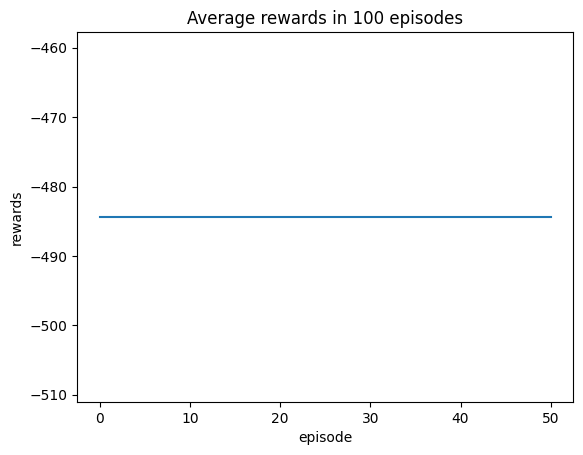

In [ ]:
for episode in range(num_episode):
    states = env.reset()
    episode_reward = 0
    for t in range(max_steps):
        actions = agents.get_action(states)
        next_states, rewards, dones, _ = env.step(actions)
        episode_reward += sum(rewards)
        for i in range(num_agent):
          batch = Batch({'obs': states[i], 'act': actions[i], 'rew': rewards[i], 'obs_next': next_states[i], 'terminated': dones[i], 'truncated': dones[i]})
          agents.learner.pri_buffer.add(batch)
        states = next_states
        if all(dones):
            break
    if episode % 5 == 0:
        agents.learner.update()
    episode_rewards.append(episode_reward)
    if episode % 100 == 0:
        print("Episode %d finished | Episode reward %f" % (episode, episode_reward))

# Compute the moving average of cumulative rewards
moving_average = np.convolve(episode_rewards, np.ones(num_average_epidodes)/num_average_epidodes, mode='valid')
plt.plot(np.arange(len(moving_average)),moving_average)
plt.title('Average rewards in %d episodes' % num_average_epidodes)
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()

env.close()

## Test agent

In [ ]:
states = env.reset()
episode_reward = 0

for t in range(max_steps):
    actions = agents.get_action(states,greedy=True)
    next_states, rewards, dones, _ = env.step(actions)
    episode_reward += sum(rewards)

    states = next_states
print(episode_reward)

-753.7678919297822
